This script should be run in a folder containing the file 'data.dat'

This file should be a two column, tab delimited file without any headers. When lxcat files are exported from the lxcat website in .txt form, the individual cross sections should be copy and pasted from the .txt file into the data.dat file without any headers. This should leave the data.dat file in the correct format for this script.

In [1]:

import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import math
import lmfit

# define data.dat file

file_path = 'data.dat'

# read data.dat and copy the contents to a pandas DataFrame

try:
    # Assuming data is in a structured format like CSV or similar
    df = pd.read_csv(file_path, delimiter='\t')
    #print(df)
 
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# define the names of the columns for the pandas DataFrame
columns = ['energy','cross section']

# assign column names to DataFrame

df.columns = columns

# define a new data frame, with the same column names as the data from data.dat
# this frame has energy value 0.0 and cross section 0.0 

df0 = pd.DataFrame([(0.0, 0.0)], columns = columns)

# append the cross section data from data.dat to the 0, 0 data to ensure that the cross section starts at 0, 0
# if this is not done it can cause problems later

df = df0._append(df)


Text(0, 0.5, 'cross section / m$^2$')

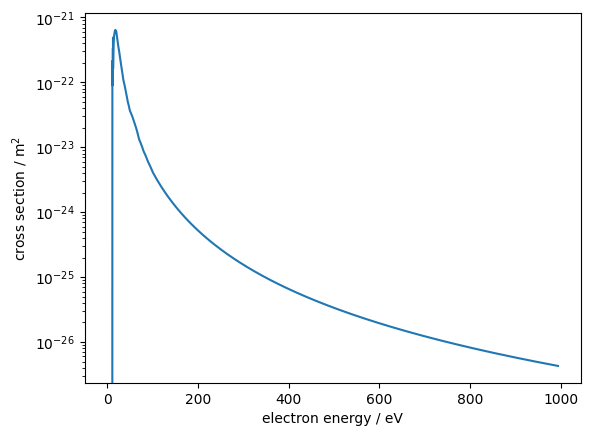

In [2]:
#print(df)

# plot imported cross section data - cross check that it is consistent with that from lxcat

plt.semilogy(df["energy"],df["cross section"])

plt.xlabel("electron energy / eV")
plt.ylabel("cross section / m$^2$")

In [3]:
# define constants for EEDF calculation
# EEDF calculation according to section 4.2 in J. R. Hamilton et al 2018 Plasma Sources Sci. Technol. 27 095008
# This is in turn from Gudmundsson J 2001 Plasma Sources Sci. Technol. 10 76

x = 1.0 # x = 1.0 defines Maxwellian EEDF
e = 1.6e-19 # electron charge SI Units
me = 9.10383632e-31 # electron mass SI units
Te = np.linspace(0.001, 6, num=1000) # range of electron temperature, in eV, over which we want to calculate rate coefficients
mean_ee = (3/2)*Te # conversion from electron temperature (Te) in eV to mean electron energy (mean_ee) in eV

dee = 0.01 # energy grid for calculation of EEDF
emax = 100.0 # maximum energy for calculation of EEDF
steps = emax/dee # number of steps in EEDF grid
ee = np.linspace(0.0,emax-dee,num=int(steps)) # define energy points on EEDF grid

xi1 = 3/(2*x) # factor in EEDF calculation
xi2 = 5/(2*x) # factor in EEDF calculation

j=0 # counter for interating over energy grid to calculate EEDF below

EEDF = np.zeros((int(steps),len(mean_ee))) # initialise EEDF as numpy array

# loop over range of mean electron energy and EEDF grid to calculate an EEDF for each mean electron energy (mean_ee)
# at each point on the EEDF grid (ee)

for ii in range (0, len(mean_ee)):

    c1 = (x/mean_ee[ii]**(3/2))*(math.gamma(xi2)**(3/2))/(math.gamma(xi1)**(5/2)) # define c1 factor for given mean_ee
    c2 = (1/mean_ee[ii]**x)*(math.gamma(xi2)/math.gamma(xi1))**x # define c2 factor for given mean_ee 
    for i in np.arange(0.0, emax-dee, dee):
        EEDF[j,ii] =c1*i**(1/2)*np.exp(-c2*i**x) # loop over ee to define EEDF for a given mean_ee at all values of ee
        j=j+1
    j=0 # reset counter


(1e-06, 1)

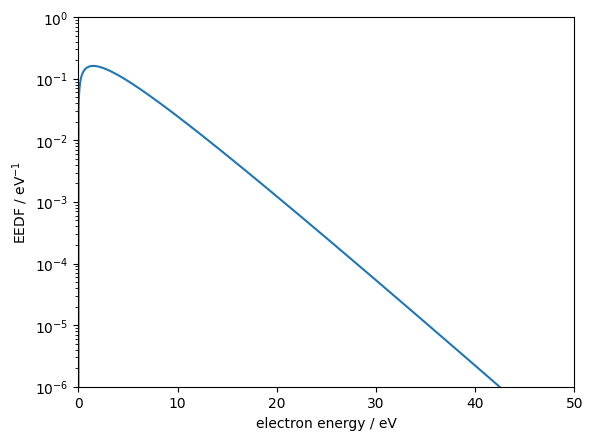

In [4]:
# check if EEDFs look reasonable
# find index column of EEDF array where Te is equal to a value defined by "find"

find = 3
difference = np.absolute(Te-find)
index = difference.argmin()
#print(index)

plt.semilogy(ee, EEDF[:,index])
#plt.semilogy(ee, EEDF[:,1])

plt.xlabel("electron energy / eV")
plt.ylabel("EEDF / eV$^{-1}$")

plt.xlim(0,50)
plt.ylim(1e-6, 1)

False


c:\Users\ag1085\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1e-25, 1e-20)

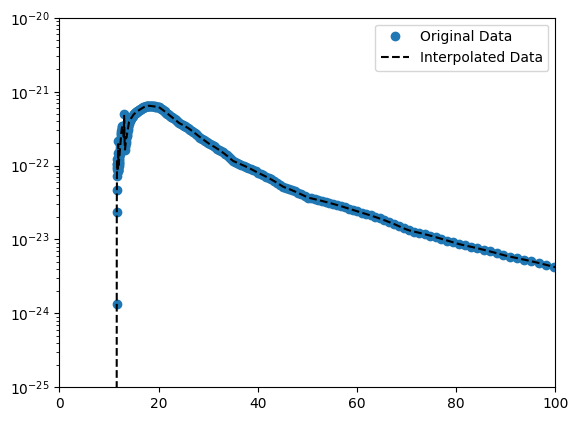

In [5]:
# here, the cross section data is being interpolated in preparation for the calcualtion of rate coefficients
# this is needed to put the cross section data on the same energy grid as the EEDFs i.e. ee
# because the cross sections have an exponential dependence on energy at low energies, and this is important for
# the rate coefficients at low energies, the data is first transformed into log10 form 
# after that the interpolation takes place in log10space. This ensures that cross sections with low values around
# the energy threshold are not missed by the interpolation
# after interpolation, the log10 conversion is reversed
# the original transformation into log10 space will create "-inf" values in the data_log array where the original 
# DataFrame, df, has 0 values. These can be ignored, but do produce an error at the end of this section of code.
# There may be a neat way to avoid this error, but it can be ignored for now

data_log = 10*np.log10(df.loc[:,"cross section"])

data_log_interpolated = np.interp(ee, df.loc[:,"energy"], data_log)
#data_log_interpolated[data_log_interpolated == -inf] = 0.0
data_linear_interpolated = 10**(data_log_interpolated/10)

# this function will check if there are, for some reason, any NaN values in the interpolated data
# if False is printed, there were no NaN
# if True is printed, there were NaN and the output should be checked carefully

print(any(np.isnan(data_linear_interpolated)))

# plot to check if original and interpolated data are the same

plt.semilogy(df["energy"],df["cross section"], "o", label="Original Data")
plt.semilogy(ee, data_linear_interpolated, "k--", label="Interpolated Data")
plt.legend()

plt.xlim(0,100)
plt.ylim(1e-25,1e-20)

Text(0, 0.5, 'rate coefficient / m$^3$s$^{-1}$')

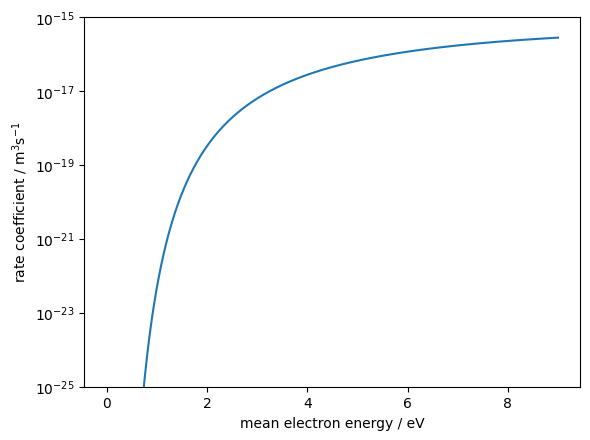

In [ ]:
# in this cell, the rate constants, k, are calculated as a function of mean electron energy mean_ee


k_data = np.zeros(len(mean_ee)) # initialise k_data, to store rate coefficients as function of mean_ee, as numpy array

# perform calculation of rate coefficients, looping over mean_ee
# equation within loop is the numerical implementation of equation (2) 
# in J. R. Hamilton et al 2018 Plasma Sources Sci. Technol. 27 095008
for k in range (0, len(mean_ee)):
    k_data[k] = np.sqrt(2*e/me) * np.trapezoid(data_linear_interpolated*EEDF[:, k]*np.sqrt(ee)*dee)
    
# plot to check that rate coefficients appear reasonable
plt.semilogy(mean_ee,k_data)
plt.ylim(1e-25,1e-15)
plt.xlabel("mean electron energy / eV")
plt.ylabel("rate coefficient / m$^3$s$^{-1}$")

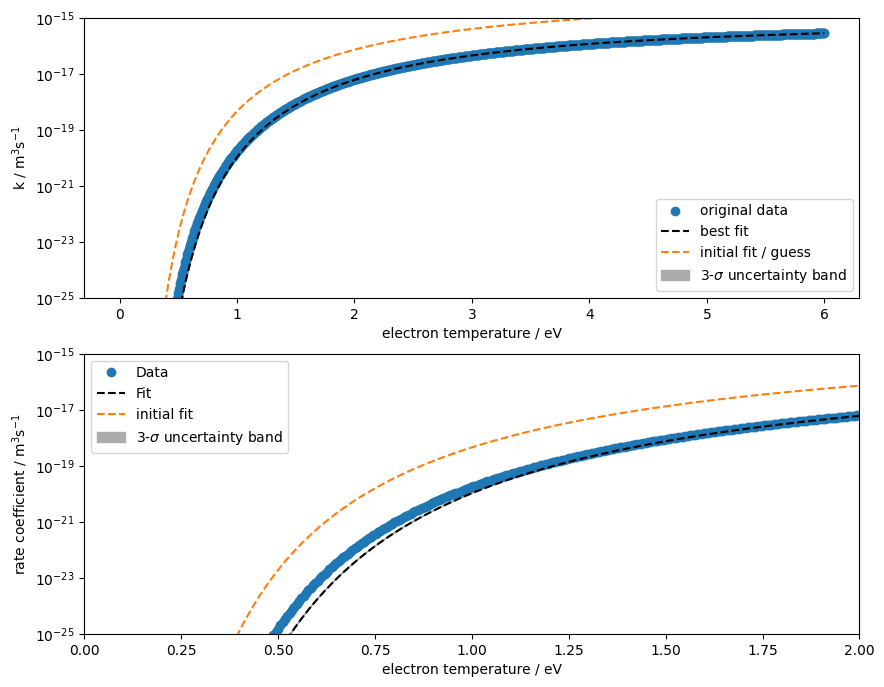

In [7]:
# in this block, the calculated rate coefficients are fitted as a function of Te (not mean_ee) 
# to provide an analytical expression for the value of the rate coefficient as a function of Te
# that can be used directly in the input file to our global model
# the reason for using Te instead of mean_ee is because it is conventional to use a function of Te to represent
# rate coefficients. Note that the only difference between Te and mean_ee is a factor 3/2

# assign Te and k_data to new numpy arrays and define data type as float (this is just to ensure that they 
# are definitely in the correct format, to avoid type errors)
x_val = np.array(Te, dtype=float)
y_val = np.array(k_data, dtype=float)

#y[y == 0.0] = 1.0

# define our fitting function as an Arrenhius expression. This is a general, and physically sensible function 
# for rate coefficients. One aspect to pay attention to is that the magnitude of the "c" coefficient
# should be similar to the energy threshold for the process
def func(x, a, b, c):
    return a*(x**b)*np.exp(c/x)

# define the fit model used in lmfit to be the Arrenhius expression defined above
regressor = lmfit.Model(func)

# make initial guess for coefficients. These should be suitable for most processes with a relatively high
# energy threshold (e.g. 5 eV and above), but may need to be varied if a suitable fit is not obtained
initial_guess = dict(a=1e-14, b=0.1, c=-10)

results = regressor.fit(y_val, x=x_val, **initial_guess) # carry out fit, results contained in "results"
y_fit = results.best_fit # define y_fit as the best fit calculated from results    


# plot results and examine various aspects to check that they make sense and are useful
plt.figure(figsize = (10,8))

plt.subplot(2, 1, 1)
plt.semilogy(x_val, y_val, "o", label="original data") # plot original data
plt.semilogy(x_val, y_fit, "k--", label="best fit") # plot best fit
plt.semilogy(x_val, results.init_fit, '--', label='initial fit / guess') # plot initial fit from initial guess

# the following provides a measure of uncertainty (3 sigma = 3 standard deviations of the mean) in the fit and plots the result as a grey shaded area in figure
dely = results.eval_uncertainty(sigma=3)
plt.fill_between(x_val, results.best_fit-dely, results.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band')

plt.xlabel("electron temperature / eV")
plt.ylabel("k / m$^3$s$^{-1}$")
plt.legend()
plt.ylim(1e-25,1e-15)

# below is the same as above, but with a more limited x axis range that focuses on the threshold region as this is an area
# that can be difficult to fit properly
plt.subplot(2, 1, 2)
plt.semilogy(x_val, y_val, "o", label="Data")
plt.semilogy(x_val, y_fit, "k--", label="Fit")
plt.semilogy(x_val, results.init_fit, '--', label='initial fit')
dely = results.eval_uncertainty(sigma=3)
plt.fill_between(x_val, results.best_fit-dely, results.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band')
plt.xlim(0,2)
plt.ylim(1e-25,1e-15)
plt.xlabel("electron temperature / eV")
plt.ylabel("rate coefficient / m$^3$s$^{-1}$")


plt.xlabel("electron temperature / eV")
plt.ylabel("rate coefficient / m$^3$s$^{-1}$")

plt.legend()

#print(lmfit.fit_report(results.params))




C:\Users\ag1085\AppData\Local\Temp\ipykernel_17672\501385898.py:35: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(x_val, np.absolute(results.residual)/y_val, label="residual / original data")
C:\Users\ag1085\AppData\Local\Temp\ipykernel_17672\501385898.py:36: RuntimeWarning: divide by zero encountered in divide
  plt.semilogy(x_val, np.absolute(results.residual)/y_fit, '--', label="residual / best fit")
C:\Users\ag1085\AppData\Local\Temp\ipykernel_17672\501385898.py:36: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(x_val, np.absolute(results.residual)/y_fit, '--', label="residual / best fit")


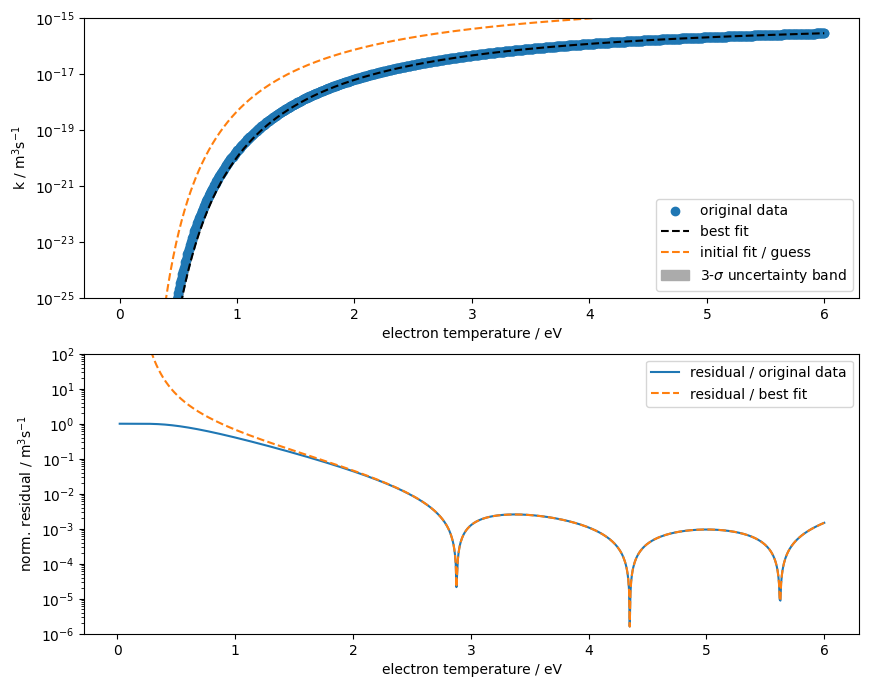

In [8]:
# in the plots above we can see that the quality of the fit varies a little with Te
# this can be assessed more quantitatively by looking at the "residual" of the fit. 
# This quantifies the difference between the fit and the data which is being fitted

# first figure is the same as the first figure above
plt.figure(figsize = (10,8))

plt.subplot(2, 1, 1)
plt.semilogy(x_val, y_val, "o", label="original data") # plot original data
plt.semilogy(x_val, y_fit, "k--", label="best fit") # plot best fit
plt.semilogy(x_val, results.init_fit, '--', label='initial fit / guess') # plot initial fit from initial guess

# the following provides a measure of uncertainty (3 sigma = 3 standard deviations of the mean) in the fit and plots the result as a grey shaded area in figure
dely = results.eval_uncertainty(sigma=3)
plt.fill_between(x_val, results.best_fit-dely, results.best_fit+dely, color="#ABABAB",
                 label=r'3-$\sigma$ uncertainty band')

plt.xlabel("electron temperature / eV")
plt.ylabel("k / m$^3$s$^{-1}$")
plt.legend()
plt.ylim(1e-25,1e-15)

# the figure below plots the residual of the fit (accessed as results.residual) divided by the value of the fit itself, as well as the residual
# divided by the value of the data
# both give a normalised view of the residual i.e. how big is it relevant to the data or fit itself
# this can be more useful than the residual itself, as the relative importance is generally more useful than the absolute residual when the value of
# the data itself varies by several orders of magnitude
# a "good" fit is indicated when both of these quantities are much less than 1
# for this data, this generally occurs at Te above than around 2 eV, as the fit gets worse a lower values
# so quantitatively, we can say the fit is proper above 2 eV
# However, since the values themselves are very low below 2 eV, even relatively large differences should not affect the final plasma model much, especially
# since Te is generally larger than 2 eV in our plasma systems
# So, we can probably use the fit over the whole range, but we should keep in mind that we have larger uncertainties at low Te 
plt.subplot(2, 1, 2)
plt.semilogy(x_val, np.absolute(results.residual)/y_val, label="residual / original data")
plt.semilogy(x_val, np.absolute(results.residual)/y_fit, '--', label="residual / best fit")

plt.ylim(1e-6,100)
plt.xlabel("electron temperature / eV")
plt.ylabel("norm. residual / m$^3$s$^{-1}$")

plt.legend()


In [9]:
# lastly, for use in the plasma model, we need the actual a, b and c coefficients
# these can be accessed as below and are found under [[Variables]]

print(results.fit_report())

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1000
    # variables        = 3
    chi-square         = 2.2307e-35
    reduced chi-square = 2.2374e-38
    Akaike info crit   = -86689.9252
    Bayesian info crit = -86675.2020
    R-squared          = 1.00000000
[[Variables]]
    a:  8.4962e-15 +/- 4.4911e-17 (0.53%) (init = 1e-14)
    b: -0.64061338 +/- 0.00210550 (0.33%) (init = 0.1)
    c: -13.6086203 +/- 0.00940319 (0.07%) (init = -10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.9990
    C(a, c) = -0.9968
    C(b, c) = +0.9924
